# Training a 3D CNN

In [1]:
import re
import pathlib
import torchvision

from fastai.basics import *
from fastai.medical.imaging import *
from fastai.vision.all import *
from fastai.callback.all import *
import fastai

from faimed3d.basics import *
from faimed3d.augment import *
from faimed3d.models import *
from faimed3d.data import *

In [2]:
torch.cuda.set_device(1)

## Create Pytorch Dataloaders

In [3]:
train = pathlib.Path('../../dl-prostate-mapping/data/train')
valid = pathlib.Path('../../dl-prostate-mapping/data/valid')
test = pathlib.Path('../../dl-prostate-mapping/data/test')

train_files = list(train.rglob('DICOM')) + list(train.rglob('T2W'))
valid_files = list(valid.rglob('DICOM'))
test_files = list(test.rglob('DICOM'))

# take only T2 and T1 images for noe
subset_train =[]
for f in train_files: 
    m = re.search(r'T2', str(f)) 
    if hasattr(m, 'string'): subset_train.append(Path(m.string))
        
subset_valid =[]
for f in valid_files: 
    m = re.search(r'T2', str(f)) 
    if hasattr(m, 'string'): subset_valid.append(Path(m.string))
        
subset_test = []
for f in test_files: 
    m = re.search(r'T2', str(f)) 
    if hasattr(m, 'string'): subset_test.append(Path(m.string))
        
        
def label_func(fn):
    return re.findall(r'(Gesund|ProstataCa)', str(fn))[0]
labels = ['Gesund', 'ProstataCa']

In [4]:
gesund, krank = [], []
for f in subset_train: 
    m = re.search(r'Gesund', str(f)) 
    if hasattr(m, 'string'): 
        gesund.append(f)
    else: 
        krank.append(f)


In [6]:
len(krank),len(gesund)

(91, 41)

In [5]:
oversampled_train = random.choices(gesund, k = len(krank)-len(gesund))+krank+subset_valid
random.shuffle(oversampled_train)

In [6]:
labels = ['Gesund', 'ProstataCa']
def label_func(fn): return re.findall(r'(Gesund|ProstataCa)', str(fn))[0]

In [7]:
class ProstateDataset(torch.utils.data.Dataset):
    def __init__(self, files):
        self.files = files
        self.labels = [label_func(f) for f in files]
        self.tcat = Categorize(vocab=labels)
        self.c = len(labels)

    def set_tfms(self, tfms):
        self.tfms = tfms
    
    def load_3d_obj(self, fn=TensorDicom3D):
        t = TensorDicom3D.create(fn)
        return t.hist_scaled()
    
    def presize(self, t: TensorDicom3D):
        return ResizeCrop3D(crop_by = (0., 0.15, 0.15), 
                            resize_to = (20, 150, 150), 
                            perc_crop = True)(t)
    
    def apply_tfms(self, t: TensorDicom3D):
        return Pipeline([*self.tfms, 
                         RandomCrop3D((0, 15, 15), (0, 10, 10)), 
                         PseudoColor])(t)
        
    def __getitem__(self, i):
        file = self.load_3d_obj(self.files[i])
        cls = self.tcat(self.labels[i])
        file = self.presize(file)
        file = self.apply_tfms(file)
        return (file, torch.Tensor([cls]).squeeze())
    
    def __len__(self): return len(self.files)
    
train_ds = ProstateDataset(oversampled_train) 
train_ds.set_tfms(aug_transforms_3d(p_all =.15))

valid_ds = ProstateDataset(subset_valid)
valid_ds.set_tfms([])
test_ds = ProstateDataset(subset_test)

In [8]:
train_dl = DataLoader(train_ds, 
          batch_size = 24, 
          pin_memory = False, 
                     )
valid_dl = DataLoader(valid_ds, 
          batch_size = 24, 
          pin_memory = False, 
                     )
test_dl = DataLoader(test_ds, 
          batch_size = 24, 
          pin_memory = False, 
                    )

dls = DataLoaders(train_dl, valid_dl)
dls = dls.cuda()

In [9]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [10]:
from sklearn.metrics import roc_auc_score
roc = RocAuc()

def roc_auc_score_(
    y_true,
    y_score,
    *,
    average='macro',
    sample_weight=None,
    max_fpr=None,
    multi_class='raise',
    labels=None,
):
    y_score = y_score[:,1]
    return roc_auc_score(y_true=y_true, 
                  y_score=y_score,
                  average=average,
                  sample_weight=sample_weight,
                  max_fpr=max_fpr,
                  multi_class=multi_class,
                  labels=labels,)


roc.func = roc_auc_score_

In [13]:
learn = Learner(dls, 
                resnet_3d(n_classes = dls.c),
                opt_func = SGD, 
                loss_func = loss_func, 
                metrics = [error_rate, roc],
                model_dir = '../models/'
               )
learn = learn.to_fp16()
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,roc_auc_score_,time
0,0.691292,0.693158,0.500000,0.450000,02:02


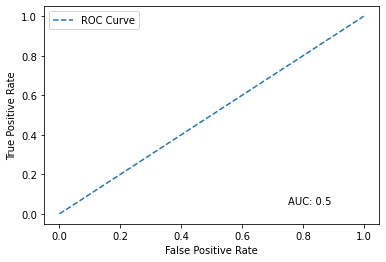

In [14]:
learn.fit_one_cycle(n_epoch = 1, lr_max = 0.05)

preds_1, target_1 = learn.get_preds()
from sklearn.metrics import roc_curve, auc

ns_fpr, ns_tpr, _ = roc_curve(target_1.numpy(), preds_1[:, 1])
learn.save('custom-resnet') # 

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.annotate('AUC: '+ str(auc(ns_fpr, ns_tpr)), (0.75, 0.05))
plt.legend()
plt.show()